# Brain Tumor MRI Torch Conv2d

In [1]:
import os
import random
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

In [2]:
data_dir = '../input/brain-tumor-mri-dataset/Training'
test_dir = '../input/brain-tumor-mri-dataset/Testing'
classes = os.listdir(data_dir)
print(classes)
print(len(classes))

['pituitary', 'notumor', 'meningioma', 'glioma']
4


In [3]:
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(80),             # resize shortest side
        transforms.CenterCrop(80),         # crop longest side
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [4]:
dataset = ImageFolder(data_dir, transform=train_transform)
testset = ImageFolder(test_dir, transform=train_transform)

In [5]:
# view one image shape of the dataset.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 80, 80])


In [6]:
# function for the showing the image.
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Label:  glioma (0)


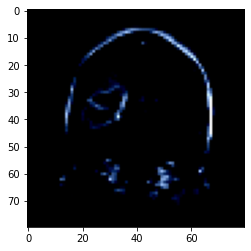

In [7]:
show_image(*dataset[20])

Label:  glioma (0)


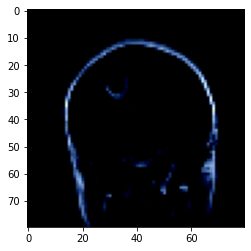

In [8]:
show_image(*dataset[100])

In [9]:
torch.manual_seed(10)
val_size = len(dataset)//10
test_size = len(testset)
train_size = len(dataset) - val_size

In [10]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
test_ds = testset
len(train_ds), len(val_ds), len(test_ds)   

(5141, 571, 1311)

In [11]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

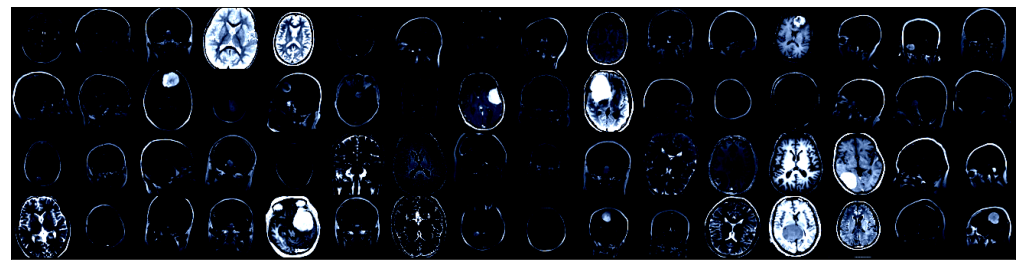

In [12]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [15]:
torch.cuda.is_available()

False

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cpu')

In [18]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [19]:
input_size = 3*80*80
output_size = len(classes)

# Conv2d Model

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                   # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [21]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 
            nn.Linear(25000, 64),  
            nn.ReLU(),            
            nn.Linear(64, 32),  
            nn.ReLU(),            
            nn.Linear(32, 16),           
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(8, output_size))
        
    def forward(self, xb):
        return self.network(xb)

In [22]:
model = CnnModel()
#model.cuda()

In [23]:
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=25000, out_features=64, bias=True)
    (17): ReLU()
    (18): Linear(in_features

In [24]:
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 80, 80])
out.shape: torch.Size([64, 4])
out[0]: tensor([-0.3742, -0.2018,  0.1807,  0.0632], grad_fn=<SelectBackward>)


In [25]:
device = get_default_device()
device

device(type='cpu')

In [26]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=25000, out_features=64, bias=True)
    (17): ReLU()
    (18): Linear(in_features

In [27]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
model = to_device(CnnModel(), device)

In [29]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 1.4294883012771606, 'val_acc': 0.24486228823661804}]

In [30]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001

In [31]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.1962, val_loss: 0.9182, val_acc: 0.6822


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.9154, val_loss: 0.8596, val_acc: 0.6564


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.7747, val_loss: 0.6547, val_acc: 0.7398


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.6570, val_loss: 0.5169, val_acc: 0.7854


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.6021, val_loss: 0.5115, val_acc: 0.8036


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.5545, val_loss: 0.4915, val_acc: 0.8109


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.5339, val_loss: 0.5206, val_acc: 0.8005


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.4912, val_loss: 0.5803, val_acc: 0.7976


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.4834, val_loss: 0.4690, val_acc: 0.8190


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.4747, val_loss: 0.4368, val_acc: 0.8255


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.4276, val_loss: 0.3758, val_acc: 0.8502


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.3947, val_loss: 0.4567, val_acc: 0.8278


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.3866, val_loss: 0.4596, val_acc: 0.8244


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.4200, val_loss: 0.4742, val_acc: 0.8380


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.4080, val_loss: 0.3716, val_acc: 0.8596


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.3838, val_loss: 0.4376, val_acc: 0.8434


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.3732, val_loss: 0.3504, val_acc: 0.8705


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.3486, val_loss: 0.3912, val_acc: 0.8596


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.3392, val_loss: 0.3706, val_acc: 0.8645


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.3462, val_loss: 0.3705, val_acc: 0.8611


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.3141, val_loss: 0.3839, val_acc: 0.8711


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.3159, val_loss: 0.4670, val_acc: 0.8554


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.3335, val_loss: 0.3553, val_acc: 0.8833


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.2686, val_loss: 0.2674, val_acc: 0.8783


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.2815, val_loss: 0.3917, val_acc: 0.8810


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.2957, val_loss: 0.3269, val_acc: 0.8703


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.2896, val_loss: 0.4228, val_acc: 0.8997


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.2693, val_loss: 0.4510, val_acc: 0.8400


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.2584, val_loss: 0.2231, val_acc: 0.9190


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.2550, val_loss: 0.4014, val_acc: 0.8512


In [32]:
#history+= fit(num_epochs, lr/10, model, train_dl, val_dl, opt_func)

In [33]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

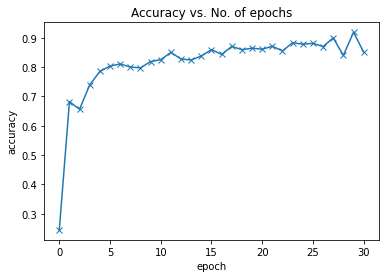

In [34]:
plot_accuracies(history)

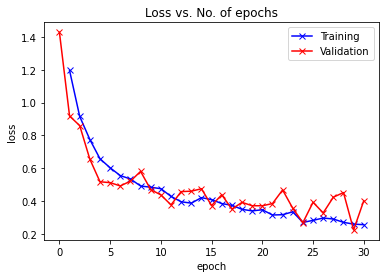

In [35]:
plot_losses(history)

In [36]:
evaluate(model, test_loader)

{'val_loss': 0.3333832323551178, 'val_acc': 0.8991477489471436}